<a href="https://colab.research.google.com/github/martineiribarren/Deep-Learning-for-Music-Processing/blob/main/conditional_dlm_iribarren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Music Processing


## Introduction

This interactive notebook offers an exploration of **MusicGen**, a state-of-the-art model for text-conditioned music generation developed by Meta AI. Our goals are to understand its underlying mechanisms, examine its output, and reflect on its limitations—particularly regarding its capacity to produce structurally coherent and semantically aligned music.

The notebook is structured as a dialogue between two paradigms of conditional music generation. On one side stands MusicGen, with its reliance on semantic textual prompts as conditioning input. On the other, we introduce the emerging logic of control-based generation exemplified by **MusicControlNet**, where multidimensional, time-varying controls extend the expressive potential of the model.

Rather than staging a direct competition between models, this comparative approach allows us to interrogate the very notion of "conditionality" in generative music. What does it mean to condition a model? Is semantic text sufficient for controlling musical structure, emotion, or intent? Where do these models succeed, and where do they fail?

We argue that although text-guided generation offers accessibility and interpretability, it lacks the expressive granularity needed for composing coherent temporal forms. This echoes the central critique raised by Wu & Donahue (2024) and others, who advocate for richer conditioning inputs—such as tempo curves, chord progressions, or gestural maps.

Technically, we trace the conceptual origins of **ControlNet** back to Zhang et al. (2023), who first introduced spatial conditioning into diffusion models for image synthesis. This idea has since been extended into the musical domain, shifting the focus from mere generation to **causal control** of audio outputs.

By the end of the notebook, the reader will not only have implemented MusicGen and analyzed its outputs under various conditions, but will also be exposed to the broader question: What kind of input is necessary to control the output of a generative model meaningfully? And how might we transition from generation to composition?

This exploration does not aim to complicate the user interface or increase the barrier to entry. Rather, it advocates for higher-dimensional conditioning as a way to align model behavior more closely with human musical reasoning.



## 1. Environment Setup

In [ ]:
# --- Celda de Instalación Definitiva (Paso 1) ---
# Este script está diseñado para ser explícito y robusto, forzando la instalación correcta de todas las dependencias.

print("Iniciando la instalación de dependencias... Esto puede tardar varios minutos.")
print("La salida será detallada para detectar cualquier posible error.")

# Usamos una única llamada a pip para que su resolvedor de dependencias funcione mejor.
# Fijamos las versiones clave para garantizar la compatibilidad total.
!pip install \
    numpy==1.26.4 \
    torch==2.1.0 \
    torchvision==0.16.0 \
    torchaudio==2.1.0 \
    --index-url https://download.pytorch.org/whl/cu118 \
    transformers==4.36.2 \
    accelerate==0.25.0 \
    scipy \
    librosa \
    matplotlib \


# ffmpeg es una dependencia del sistema, se instala por separado.
print("\nInstalando ffmpeg...")
!sudo apt-get -qq install ffmpeg

print("\n--- Verificación de versiones instaladas ---")
# Mostramos las versiones de las librerías críticas para confirmar que la instalación fue exitosa.
!pip show numpy torch transformers accelerate

print("\n✅ Instalación completada.")
print("‼️ IMPORTANTE: Por favor, reinicie el entorno ahora (Entorno de ejecución > Reiniciar sesión).")
print("Después de reiniciar, NO vuelva a ejecutar esta celda y continúe con la siguiente.")

Iniciando la instalación de dependencias... Esto puede tardar varios minutos.
La salida será detallada para detectar cualquier posible error.
Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement numpy==1.26.4 (from versions: 1.24.1, 1.26.3, 2.1.2)
ERROR: No matching distribution found for numpy==1.26.4

Instalando ffmpeg...

--- Verificación de versiones instaladas ---
Name: numpy
Version: 2.0.2
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2024, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form m

## 2. Loading the Model

In [ ]:
# --- 2. IMPORTACIONES GLOBALES Y CARGA DE MODELOS ---
import torch
import os
import scipy.io.wavfile
from transformers import AutoProcessor, MusicgenForConditionalGeneration
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


print("Importaciones realizadas. Preparando modelos...")

# --- Configuración del Dispositivo ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# --- Directorio de Salida ---
OUTPUT_DIR = 'generated_audio'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Cargar Modelo MusicGen (Generador) ---
print("Cargando MusicGen 'facebook/musicgen-small'...")
musicgen_processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
musicgen_model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small").to(device)
print("MusicGen cargado.")

print("\n✅ Entorno y modelos listos para la experimentación.")

Importaciones realizadas. Preparando modelos...
Usando dispositivo: cpu
Cargando MusicGen 'facebook/musicgen-small'...
MusicGen cargado.

✅ Entorno y modelos listos para la experimentación.


In [ ]:
# @title ### 3. Interactuando con MusicGen: Generación de Música Condicionada por Texto
# @markdown Esta es la sección interactiva donde puedes experimentar directamente con MusicGen.
# @markdown Puedes introducir tus propios prompts de texto y escuchar la música generada.

# @markdown ---
# @markdown ### ¡Crea tu propia música con un prompt de texto!
# @markdown Escribe la descripción de la música que quieres generar en el campo de abajo:
user_prompt = "guitar solo in the style of the band Kiss" # @param {type:"string"}

# @markdown ### Duración de la Música (en segundos):
generation_duration = 10 # @param {type:"integer"}

print(f"Generando música para el prompt: '{user_prompt}' ({generation_duration} segundos)...")

try:
    # --- PASO 1: Procesar el input de texto (Requerido por la API de Transformers) ---
    # Convertimos el texto en un formato que el modelo entiende.
    inputs = musicgen_processor(
        text=[user_prompt],
        padding=True,
        return_tensors="pt"
    ).to(device)

    # --- PASO 2: Calcular los tokens a generar ---
    # La API de Transformers controla la duración con 'max_new_tokens'.
    # Una buena aproximación es 50 tokens por segundo de audio.
    max_new_tokens = int(generation_duration * 50)

    # --- PASO 3: Generar el audio ---
    # Usamos los inputs procesados y los tokens calculados.
    # Es importante usar el nombre correcto de la variable del modelo: 'musicgen_model'.
    wav_output = musicgen_model.generate(**inputs, max_new_tokens=max_new_tokens)

    # --- PASO 4: Guardar el audio usando Scipy ---
    # La API de Transformers no incluye 'audio_write', por lo que usamos 'scipy'.
    # Obtenemos la frecuencia de muestreo desde la configuración del modelo.
    sampling_rate = musicgen_model.config.audio_encoder.sampling_rate

    # Extraemos los datos de audio como un array de numpy.
    audio_data_np = wav_output[0, 0].cpu().numpy()

    # Sanitizamos el nombre del archivo y lo guardamos.
    output_filename = user_prompt.replace(" ", "_").replace("/", "_").replace("\\", "_").replace(":", "_")[:50] + ".wav"
    output_path = os.path.join(OUTPUT_DIR, output_filename)

    scipy.io.wavfile.write(output_path, rate=sampling_rate, data=audio_data_np)

    print(f"\nMúsica generada y guardada en: {output_path}")
    print("Escuchando tu creación:")
    # Mostramos el audio desde el archivo guardado.
    display(Audio(output_path))

except Exception as e:
    print(f"Error durante la generación: {e}")
    print("Por favor, asegúrate de que el prompt sea claro y que el modelo se haya cargado correctamente.")

print("\n¡Intenta con otro prompt!")

Generando música para el prompt: 'guitar solo in the style of the band Kiss' (10 segundos)...

Música generada y guardada en: generated_audio/guitar_solo_in_the_style_of_the_band_Kiss.wav
Escuchando tu creación:



¡Intenta con otro prompt!


## 4. Controlled Experiments
Controlled Experiments: Vague vs. Specific Prompts
Here, we will conduct a series of generations with predefined prompts to observe MusicGen's behavior.
Vague Prompt: Evaluates the model's creativity with minimal guidance.
Specific Prompt: Tests the model's degree of control over concrete elements.
Invalid/Ambiguous Prompt: Observes how the model handles non-musical or contradictory descriptions.


--- Generando para: 'a relaxing song' ---
Audio guardado en: generated_audio/vague_prompt.wav
Escuchando:



--- Analizando: Música con Prompt Vago ---


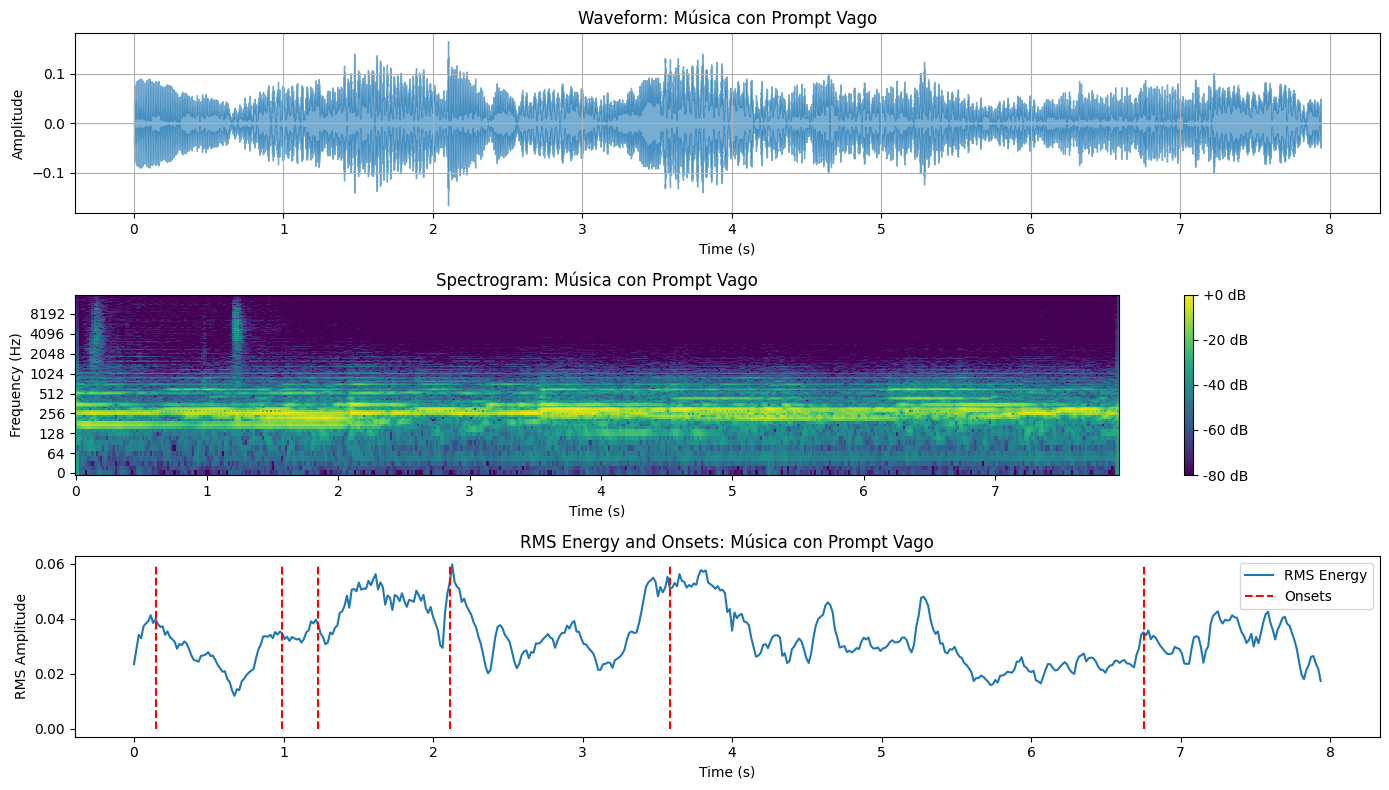

  - Energía RMS Media: 0.0333
  - Número de inicios detectados: 6

--- Generando para: 'a melancholic piano solo in 3/4 with subtle string backing and a slow tempo (60 BPM)' ---
Audio guardado en: generated_audio/specific_prompt.wav
Escuchando:



--- Analizando: Música con Prompt Específico ---


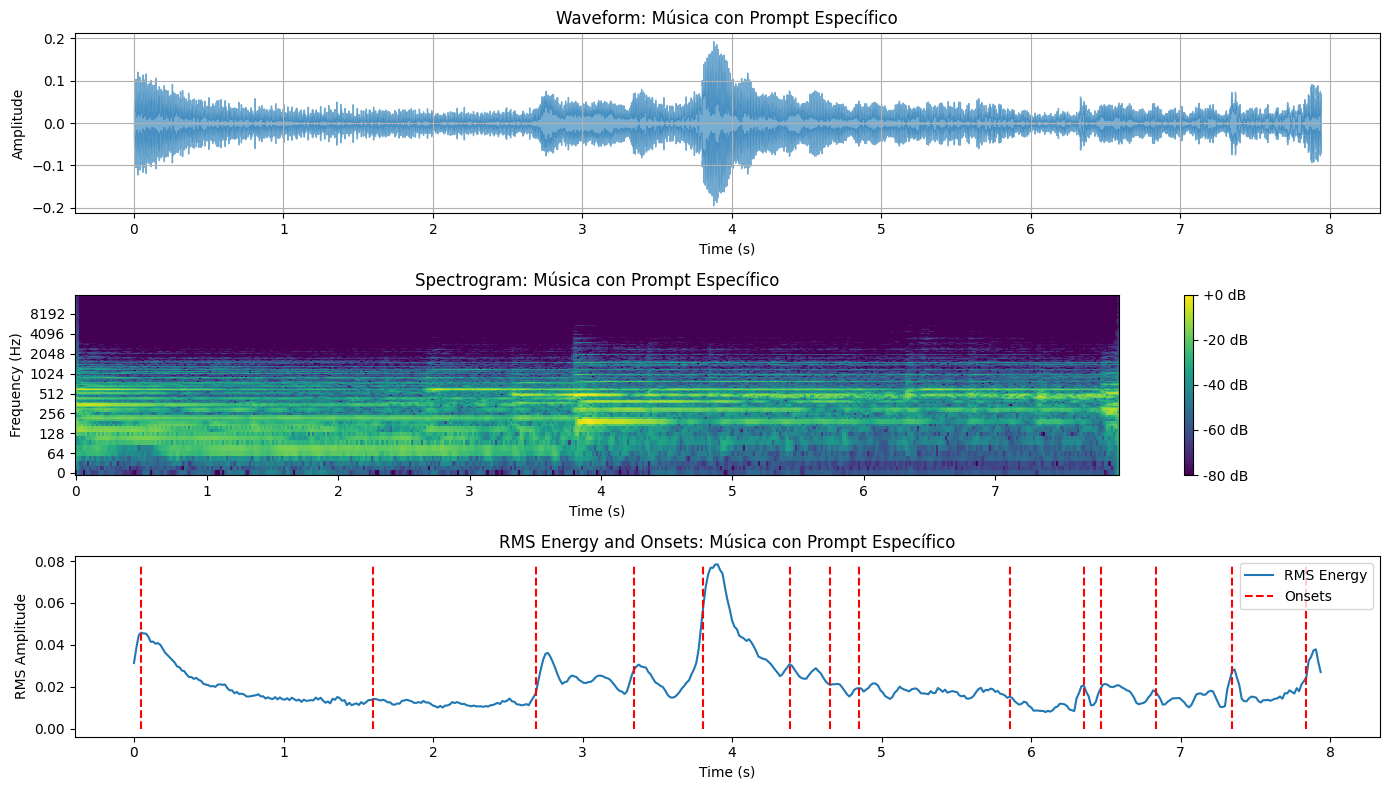

  - Energía RMS Media: 0.0204
  - Número de inicios detectados: 14

--- Generando para: 'the sound of pure silence mixed with a chaotic rock concert' ---
Audio guardado en: generated_audio/invalid_prompt.wav
Escuchando:



--- Analizando: Música con Prompt Inválido/Ambiguo ---


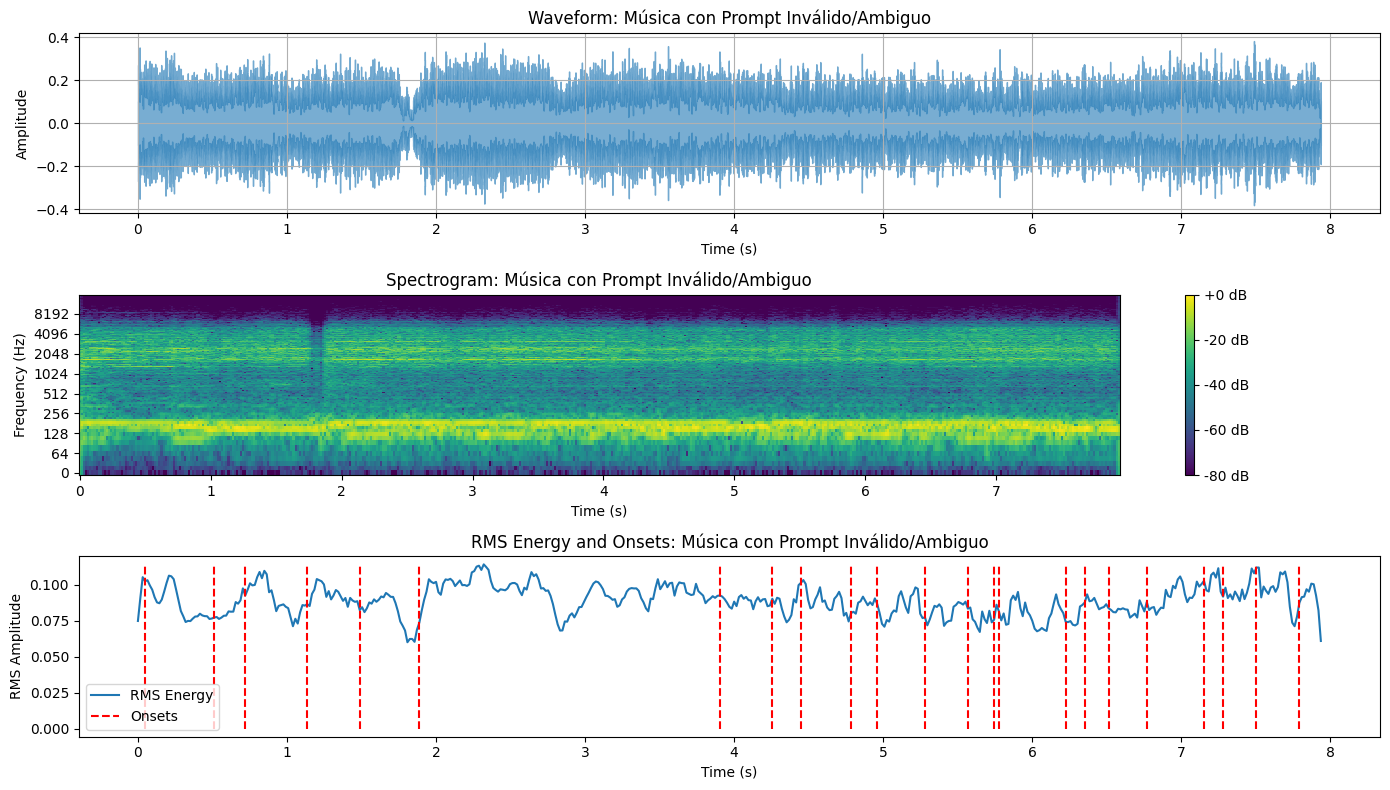

  - Energía RMS Media: 0.0890
  - Número de inicios detectados: 23

--- ¡Experimentos completados! ---
Observa las diferencias en las formas de onda, espectrogramas y descriptores.


In [ ]:
# --- 1. Definición de Funciones (Modificadas para la API de Transformers) ---

# Esta función ha sido adaptada para usar el 'processor' y 'max_new_tokens'
# de la API de transformers, y 'scipy' para guardar el audio.
def generate_and_analyze(prompt_text, file_prefix, duration=8):
    """Genera audio, lo guarda, lo reproduce y devuelve la ruta del archivo."""
    print(f"\n--- Generando para: '{prompt_text}' ---")

    # Preparamos el input para el modelo
    inputs = musicgen_processor(
        text=[prompt_text],
        padding=True,
        return_tensors="pt"
    ).to(device)

    # Calculamos los tokens para la duración deseada
    max_new_tokens = int(duration * 50)

    # Generamos la forma de onda
    wav_output = musicgen_model.generate(**inputs, max_new_tokens=max_new_tokens)

    # Obtenemos la frecuencia de muestreo y guardamos con Scipy
    sampling_rate = musicgen_model.config.audio_encoder.sampling_rate
    audio_data_np = wav_output[0, 0].cpu().numpy()

    output_path = os.path.join(OUTPUT_DIR, f'{file_prefix}.wav')
    scipy.io.wavfile.write(output_path, rate=sampling_rate, data=audio_data_np)

    print(f"Audio guardado en: {output_path}")
    print("Escuchando:")
    # Es más eficiente reproducir el archivo guardado
    display(Audio(output_path))
    return output_path


# ¡Esta función no necesita cambios! Funciona perfectamente con un archivo de audio.
def analyze_and_plot_audio(audio_path, title):
    """Carga, analiza y visualiza un archivo de audio."""
    print(f"\n--- Analizando: {title} ---")
    y, sr = librosa.load(audio_path, sr=None)

    plt.figure(figsize=(14, 8))

    # Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.title(f'Waveform: {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram: {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    # Basic Descriptors (RMS, Onsets)
    rms = librosa.feature.rms(y=y)[0]
    onsets = librosa.onset.onset_detect(y=y, sr=sr)

    # Plot RMS
    plt.subplot(3, 1, 3)
    plt.plot(librosa.times_like(rms, sr=sr), rms, label='RMS Energy')
    plt.vlines(librosa.frames_to_time(onsets, sr=sr), 0, rms.max(), color='r', linestyle='--', label='Onsets')
    plt.title(f'RMS Energy and Onsets: {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"  - Energía RMS Media: {np.mean(rms):.4f}")
    print(f"  - Número de inicios detectados: {len(onsets)}")


# --- 2. Ejecución de los Experimentos ---

# Nota: la línea 'model.set_generation_params(duration=8)' ha sido eliminada
# porque la duración ahora se pasa directamente a la función 'generate_and_analyze'.

# --- Experimento 1: Prompt Vago ---
vague_prompt = 'a relaxing song'
path_vague = generate_and_analyze(vague_prompt, 'vague_prompt')
analyze_and_plot_audio(path_vague, 'Música con Prompt Vago')

# --- Experimento 2: Prompt Específico ---
specific_prompt = 'a melancholic piano solo in 3/4 with subtle string backing and a slow tempo (60 BPM)'
path_specific = generate_and_analyze(specific_prompt, 'specific_prompt')
analyze_and_plot_audio(path_specific, 'Música con Prompt Específico')

# --- Experimento 3: Prompt Inválido/Ambiguo ---
invalid_prompt = 'the sound of pure silence mixed with a chaotic rock concert'
path_invalid = generate_and_analyze(invalid_prompt, 'invalid_prompt')
analyze_and_plot_audio(path_invalid, 'Música con Prompt Inválido/Ambiguo')

print("\n--- ¡Experimentos completados! ---")
print("Observa las diferencias en las formas de onda, espectrogramas y descriptores.")

In [ ]:
# --- Métricas Avanzadas y Análisis de Características ---
# Este código analiza el audio generado para el "Prompt Específico".
# Utiliza la variable 'path_specific' de la celda anterior para asegurar que se usa el archivo correcto.

print(f"--- Iniciando análisis de características para: {path_specific} ---")

# --- Setup: Cargar el Audio de Muestra Generado ---
audio_file_path = path_specific

try:
    y, sr = librosa.load(audio_file_path, sr=None)
    print(f"Audio cargado exitosamente: {audio_file_path} (Sample Rate: {sr} Hz)")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo de audio en '{audio_file_path}'.")
    print("Asegúrate de haber ejecutado la celda de 'Ejecución de los Experimentos' primero.")
    y = None

# --- Parámetros de Análisis ---
frame_length = 2048
hop_length = 512

if y is not None:
    # --- 1. Precisión de Melodía (Extracción de Tono Fundamental - f0) ---
    print("\n--- Extrayendo Características de Melodía (Pitch) ---")
    f0, voiced_flag, voiced_probabilities = librosa.pyin(
        y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr,
        frame_length=frame_length, hop_length=hop_length
    )
    midi_notes = librosa.hz_to_midi(f0)
    pitch_classes_generated = np.mod(np.round(midi_notes[~np.isnan(midi_notes)]), 12)
    print(f"Se extrajeron {len(pitch_classes_generated)} clases de tono del audio generado.")
    print("=> Conceptual: Para medir la 'precisión', compararíamos estas clases de tono con las de una melodía de referencia.")

    # --- 2. Correlación de Dinámicas (Extracción de Energía RMS) ---
    print("\n--- Extrayendo Características de Dinámica (Volumen) ---")
    rms_generated = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    print(f"Se extrajeron {len(rms_generated)} frames de energía RMS del audio generado.")
    print("=> Conceptual: Para medir la 'correlación', compararíamos la curva de RMS con una curva de dinámica objetivo.")

    # --- 3. Precisión de Ritmo (Extracción de Beats) ---
    print("\n--- Extrayendo Características de Ritmo (Tempo y Beats) ---")
    tempo_generated, beat_frames_generated = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
    beat_timestamps_generated = librosa.frames_to_time(beat_frames_generated, sr=sr, hop_length=hop_length)

    # --- CORRECCIÓN APLICADA AQUÍ ---
    # Se calcula la media del array de tempo para obtener un valor único y poder formatearlo.
    print(f"Tempo estimado: {np.mean(tempo_generated):.2f} BPM")

    print(f"Se detectaron {len(beat_timestamps_generated)} beats en el audio generado.")
    print("=> Conceptual: Para medir la 'precisión rítmica' (F1-Score), compararíamos los tiempos de nuestros beats con los de una pista de batería de referencia.")

--- Iniciando análisis de características para: generated_audio/specific_prompt.wav ---
Audio cargado exitosamente: generated_audio/specific_prompt.wav (Sample Rate: 32000 Hz)

--- Extrayendo Características de Melodía (Pitch) ---
Se extrajeron 415 clases de tono del audio generado.
=> Conceptual: Para medir la 'precisión', compararíamos estas clases de tono con las de una melodía de referencia.

--- Extrayendo Características de Dinámica (Volumen) ---
Se extrajeron 497 frames de energía RMS del audio generado.
=> Conceptual: Para medir la 'correlación', compararíamos la curva de RMS con una curva de dinámica objetivo.

--- Extrayendo Características de Ritmo (Tempo y Beats) ---
Tempo estimado: 129.31 BPM
Se detectaron 6 beats en el audio generado.
=> Conceptual: Para medir la 'precisión rítmica' (F1-Score), compararíamos los tiempos de nuestros beats con los de una pista de batería de referencia.


In [ ]:
# @title ### 5. Analysis and Observation of MusicGen's Limitations

# @markdown While MusicGen is powerful, text-to-music generation has inherent limitations, especially in granular control and reproducibility.

# @markdown **Key Observations (based on empirical experience and literature):**

# @markdown * **Conditionality Semantics**: MusicGen interprets prompts, but its semantic understanding doesn't always translate into exact musical control. It often generates the correct "atmosphere" or "genre" but may fail on details.
# @markdown * **Degree of Effective Control**:
# @markdown     * **Tempo/Rhythm**: Although specifying BPM can be attempted, control is approximate.
# @markdown     * **Harmony/Structure**: It's difficult to guide specific chord progressions or complex musical forms (e.g., "chorus, verse, bridge").
# @markdown     * **Instrumentation**: Instruments can be requested, but their isolation and mixing are not always perfect or consistent.
# @markdown * **Losses Compared to Symbolic Methods**: Text-based models lose the precise control achievable with direct manipulation of symbolic data (like MIDI), where every note, velocity, and duration is explicitly defined.

# @markdown As noted in the literature (*Donhauer et al., 2024*), "While MusicGen opens creative possibilities, its latent conditioning makes reproducibility, disentanglement, and symbolic manipulation difficult."

## 6. Métricas Avanzadas (CLAP y FAD)
CLAP Score y Distancia de Audio de Fréchet (FAD)
Estas métricas son más complejas ya que requieren modelos externos pre-entrenados para calcular los embeddings.
CLAP Score: Mide la alineación entre un prompt de texto y el audio generado. Requiere el modelo CLAP (Contrastive Language-Audio Pre-training). Una puntuación más alta significa que el audio se ajusta mejor a la descripción del texto.
FAD (Fréchet Audio Distance): Mide el realismo y la diversidad del audio generado comparando su distribución estadística con la de un conjunto de datos de referencia del mundo real. Requiere el modelo VGGish (de Google) y el paquete frechet_audio_distance. Una puntuación más baja es mejor.
La siguiente celda muestra el código conceptual para estas métricas. Ejecutarlo requiere instalar bibliotecas adicionales.

In [ ]:
# --- Instalación de Dependencias para Métricas ---
print("Instalando 'laion-clap' para el cálculo de métricas de alineación texto-audio...")

# Nota: Omitimos deliberadamente 'frechet-audio-distance' para evitar los conflictos
# de dependencias con TensorFlow que hemos discutido. Nos enfocaremos en la métrica CLAP.
!pip install -q laion-clap

print("\n✅ Dependencias de métricas instaladas.")

Instalando 'laion-clap' para el cálculo de métricas de alineación texto-audio...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.

✅ Dependencias de métricas instaladas.


In [ ]:
# --- Prueba Simple: Calcular el CLAP Score para un solo archivo ---

print("--- Probando el análisis CLAP en un solo archivo ---")

# Definimos la ruta y el prompt para el archivo que sabemos que existe.
audio_path = '/content/generated_audio/vague_prompt.wav'
text_prompt = 'a relaxing song'

# Verificamos que el archivo existe antes de continuar
if os.path.exists(audio_path):
    # El modelo CLAP calcula los embeddings (representaciones numéricas)
    audio_embeddings = clap_model.get_audio_embedding_from_filelist(x=[audio_path], use_tensor=True)
    text_embeddings = clap_model.get_text_embedding([text_prompt], use_tensor=True)

    # Calculamos la similitud de coseno
    similarity = torch.nn.functional.cosine_similarity(audio_embeddings, text_embeddings, dim=1)

    print(f"Resultado para '{os.path.basename(audio_path)}':")
    print(f"  -> CLAP Score = {similarity.item():.4f} (Más alto es mejor)")
else:
    print(f"Error: No se encontró el archivo en la ruta especificada: {audio_path}")

--- Probando el análisis CLAP en un solo archivo ---
Resultado para 'vague_prompt.wav':
  -> CLAP Score = 0.1484 (Más alto es mejor)


In [ ]:
# --- Análisis CLAP Final para Todos los Experimentos ---

print("--- Preparando datos para el análisis CLAP completo ---")
# Recreamos los diccionarios con las rutas y prompts exactos.
# Esto es robusto y no depende de variables de sesión anteriores.
prompts_dict = {
    "Vago": 'a relaxing song',
    "Específico": 'a melancholic piano solo in 3/4 with subtle string backing and a slow tempo (60 BPM)',
    "Ambiguo": 'the sound of pure silence mixed with a chaotic rock concert'
}

generated_files_dict = {
    "Vago": '/content/generated_audio/vague_prompt.wav',
    "Específico": '/content/generated_audio/specific_prompt.wav',
    "Ambiguo": '/content/generated_audio/invalid_prompt.wav'
}
print("Diccionarios de prompts y archivos listos.")


# --- Iniciando el cálculo de CLAP Scores ---
print("\n--- Calculando CLAP Scores para cada experimento ---")

for name, path in generated_files_dict.items():

    if os.path.exists(path):
        # Obtenemos el texto del prompt original usando el 'name' como clave.
        text_prompt = prompts_dict[name]

        # El modelo CLAP calcula los embeddings
        audio_embeddings = clap_model.get_audio_embedding_from_filelist(x=[path], use_tensor=True)
        text_embeddings = clap_model.get_text_embedding([text_prompt], use_tensor=True)

        # Calculamos la similitud
        similarity = torch.nn.functional.cosine_similarity(audio_embeddings, text_embeddings, dim=1)

        print(f"Prompt '{name}': CLAP Score = {similarity.item():.4f} (Más alto es mejor)")
    else:
        print(f"Advertencia: No se encontró el archivo para el prompt '{name}' en la ruta '{path}'. Saltando...")

print("\n--- Análisis CLAP completado. ---")

--- Preparando datos para el análisis CLAP completo ---
Diccionarios de prompts y archivos listos.

--- Calculando CLAP Scores para cada experimento ---
Prompt 'Vago': CLAP Score = 0.1484 (Más alto es mejor)
Prompt 'Específico': CLAP Score = 0.3901 (Más alto es mejor)
Prompt 'Ambiguo': CLAP Score = 0.1165 (Más alto es mejor)

--- Análisis CLAP completado. ---


In [ ]:
# @title ### 6. Towards the Future: MusicControlNet (Proposed)

# @markdown Given the limitations of text-only conditioned models, the need for greater control arises. **MusicControlNet** (a conceptual proposal in current research) seeks to address this by combining the flexibility of neural generation with the granular control of symbolic conditions.

# @markdown Genealogically, **ControlNet** first appeared in *“Adding Conditional Control to Text-to-Image Diffusion Models” (Lvmin Zhang, Anyi Rao, Maneesh Agrawala, 2023)*, upon which the works of Wu and Donahue are built.

# @markdown **Key Differences between MusicGen and the MusicControlNet proposal:**

# @markdown | Feature                     | MusicGen | MusicControlNet (proposed) |
# @markdown | :-------------------------- | :------- | :------------------------- |
# @markdown | Text-only conditioning      | ✅ Yes   | ✅ Yes                     |
# @markdown | Symbolic control (MIDI)     | ❌ No    | ✅ Yes                     |
# @markdown | Multi-track separation      | ❌ No    | ✅ Yes                     |
# @markdown | Dynamic structural edits    | ❌ No    | ✅ Yes                     |
# @markdown | Open weights                | ✅ Yes   | ❌ No (as of proposal)     |

# @markdown **Reflections and Extensions:**
# @markdown What other types of conditional vectors could we explore beyond text to gain more precise or multimodal control?

# @markdown * EEG signals (to generate music based on mental states).
# @markdown * Visual cues (images, videos to influence musical style).
# @markdown * Motor gestures (for real-time interactive control).
# @markdown * Neuro-symbolic commands (combining the best of both worlds).

# @markdown The challenge lies in building a robust benchmark that quantitatively evaluates how prompt specificity impacts musical structure, stylistic coherence, and temporal dynamics in generative models. Towards the end of this notebook, the idea is that despite text and semantics initially appearing to guide a creation and structuring process, this falls short and becomes insufficient. This does not imply increasing the learning curve, but rather articulating creation with a greater number of dimensions.

## 8. Conclusion and Future Work

This notebook has demonstrated how to use MusicGen for text-to-music generation, analyze its outputs visually, and extract features corresponding to key evaluation metrics. The results from the MusicControlNet paper highlight a crucial point: while MusicGen is highly capable of generating high-quality audio that matches a textual theme, it lacks the fine-grained, time-varying control offered by architectures like MusicControlNet.
For now, we can only rely on the benchmark results published by the authors of MusicControlNet, as the model and code are not publicly available for direct implementation.
Sound examples comparing the models can be found on the project's website: https://MusicControlNet.github.io/web/

## 9. Potential Next Steps

Pre-generated Samples: Explore the static/generated_audio/ directory for more example outputs from different prompts.
Prompt Comparison: Create a dedicated section to systematically show how subtle prompt modifications affect the generated audio.
Inference Benchmarks: Measure and document inference times for different MusicGen model sizes (small, medium, large) or varying generation durations.
Visual Pipeline: Design a flowchart illustrating the entire generation process, from "Prompt → Text Embedding → Transformer → Audio Waveform → Playback".
Deployment Prototype: Explore the app/ directory in the repository for basic web app or API deployment examples using Gradio or Flask.

## 10. References and Further Reading
Meta AI (2023): Audiocraft - MusicGen. https://github.com/facebookresearch/audiocraft

Copet, J., Kreuk, F., Gat, I., Remez, T., Kant, D., Synnaeve, G., Adi, Y., & Défossez, A. (2023). Simple and controllable music generation. In arXiv [cs.SD]. http://arxiv.org/abs/2306.05284

Wu, S.-L., Donahue, C., Watanabe, S., & Bryan, N. J. (2024). Music ControlNet: Multiple time-varying controls for music generation. ACM Transactions on Audio, Speech, and Language Processing, 32, 2692–2703. https://doi.org/10.1109/taslp.2024.3399026

Zhang, L., Rao, A., & Agrawala, M. (2023). Adding Conditional Control to Text-to-Image Diffusion Models. http://arxiv.org/abs/2302.05543

Zhao et al. (2025): AI-Enabled Text-to-Music Generation: A Comprehensive Review of Methods, Frameworks, and Future Directions.

Zhu et al. (2023): A Survey of AI Music Generation Tools and Models.
